# Generating MNIST digits using simple GAN

In this tutorial, we see how new images are generated from random noise.
A simple GAN architecture is trained on MNIST and can create new images.

Below we import the necessary libraries and load the data

In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

We plot some of the images. These images are grayscale of size 28 * 28.
As there is only one channel, the intensities vary from 0 to 255.

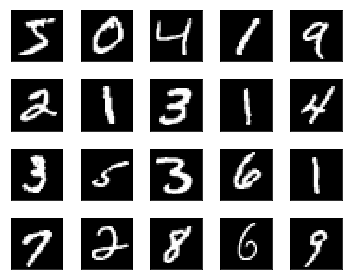

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [4]:
X_train.min(), X_train.max()

(0, 255)

A generator takes in random noise and creates hand-written images.
We create noise data as normal distribution of randomly generated numbers

In [5]:
def make_latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

# generates one sample
make_latent_samples(1, 100)

array([[-5.52195974e-01, -1.94637975e+00,  7.00926689e-01,
        -1.05067249e+00, -9.62951355e-01, -3.99003303e-01,
         1.95430742e+00, -2.50745347e+00,  1.33650345e+00,
        -4.09556418e-01, -2.02448626e-03, -5.66106318e-01,
        -8.71069155e-02, -5.65423537e-01, -1.34899896e+00,
         1.11624859e+00, -1.52660733e+00,  1.50362635e+00,
         1.51405836e+00, -2.67189687e-01,  2.13088522e-01,
         5.56222371e-01,  1.41558894e+00, -6.17830742e-01,
        -7.38190736e-01,  6.51714396e-01,  1.38911003e-01,
         2.82186022e-02,  5.61078366e-01,  7.24417586e-01,
         2.22203674e+00, -3.09961975e-01, -8.82415386e-01,
         1.21067590e+00, -1.27599707e+00,  8.34432428e-01,
         1.40202808e+00,  1.37405085e+00,  2.08335616e+00,
        -4.30139964e-01, -3.85553026e-01, -9.31617772e-01,
         4.49226406e-01,  1.16397183e+00, -1.12539390e+00,
         4.46797856e-01, -1.00763170e+00, -2.57292060e-01,
        -1.19109137e+00, -1.57753745e+00,  5.80992904e-0

Discriminator network is trained before hand and then made non-trainable.
Discriminator needs to be made non-trainable so that the weights in adverserial part are freezed and the generative network of GAN is able to bring noisy data more closer to fool the discriminator.

In [6]:
def  make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

GAN is a generator and discriminator stacked together.
1. Genertaor network here will be a simple one, which takes in a latent space and should give a digit.
*tanh* activation gives better result, so it will be used here. Due to this another step of pre and post image processing is introduced.
2. A discriminator's job is to identify whether or not the input digit provided is real or fake.
Here, it takes in input digit and classifies it into 1 or 0 (real or fake).

In [7]:
def make_simple_GAN(sample_size, 
                    g_hidden_size, 
                    d_hidden_size, 
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(784),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size, input_shape=(784,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [8]:
def preprocess(x):    
    x = x.reshape(-1, 784) # 784=28*28
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

In [9]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

y_real_10, y_fake_10 = make_labels(10)

To train the gain, below are the steps followed:
- a batch of real images
- a batch of fake images generated by the generator using latent samples
- Make the discriminator trainable and train the discriminator to classify the real and fake images
- Make the discriminator non-trainable and train the generator

In [10]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))

c:\garage\venv\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/100 Discriminator Loss: 0.2556 Generator Loss: 3.5080
Epoch:   2/100 Discriminator Loss: 0.6709 Generator Loss: 4.3466
Epoch:   3/100 Discriminator Loss: 0.2685 Generator Loss: 1.8762
Epoch:   4/100 Discriminator Loss: 0.3945 Generator Loss: 2.7340
Epoch:   5/100 Discriminator Loss: 0.3438 Generator Loss: 8.2208
Epoch:   6/100 Discriminator Loss: 0.2745 Generator Loss: 2.3266
Epoch:   7/100 Discriminator Loss: 0.2139 Generator Loss: 2.1670
Epoch:   8/100 Discriminator Loss: 0.3235 Generator Loss: 3.2472
Epoch:   9/100 Discriminator Loss: 0.3445 Generator Loss: 3.8243
Epoch:  10/100 Discriminator Loss: 1.0274 Generator Loss: 0.6727
Epoch:  11/100 Discriminator Loss: 0.2375 Generator Loss: 3.9818
Epoch:  12/100 Discriminator Loss: 0.3398 Generator Loss: 2.6713
Epoch:  13/100 Discriminator Loss: 0.3442 Generator Loss: 2.9125
Epoch:  14/100 Discriminator Loss: 0.2438 Generator Loss: 2.1083
Epoch:  15/100 Discriminator Loss: 0.2889 Generator Loss: 2.3958
Epoch:  16/100 Discrimina

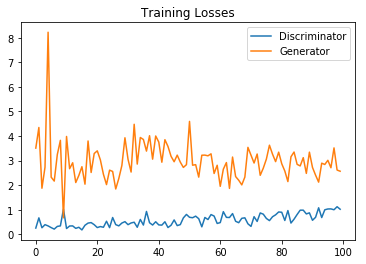

In [11]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

Below are the results; digits generated from the generator

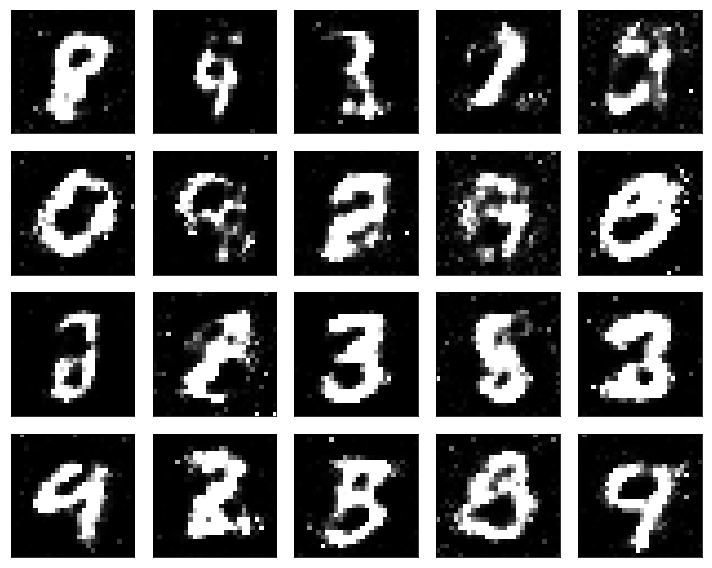

In [14]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

I also recommend to check Deep Convolution GAN aka DCGAN for improved results.